In [1]:
using JuMP, PolyJuMP, MultivariatePolynomials, DynamicPolynomials, SumOfSquares, LinearAlgebra

struct Box
    xl::Float64
    xu::Float64
    yl::Float64
    yu::Float64
end

function solveModel(npieces,degree,boxes::Array{Box},domain::Box,startcondition,endcondition,misdpsolver,tol_int = 1e-9, tol_feas = 1e-9, tol_gap = 1e-6)

    model = SOSModel(solver=misdpsolver)

    tol_nonneg = tol_feas # Tolerance for polynomial nonnegativity

    (X₀, X₀′, X₀′′) = startcondition
    (X₁, X₁′, X₁′′) = endcondition

    # Discretize time into npieces+1 times
    Tmin = 0.
    Tmax = 1.
    T = range(Tmin, stop = Tmax, length = npieces+1)

    # Polynomials are a function of t
    @polyvar(t)
    Z = monomials(t, 0:degree)

    # Binary variables to choose safe regions
    # variables are indexed by trajectory piece (integer 1:npieces) and boxes (of type Box)
    @variable(model, H[1:npieces,boxes], Bin)

    # Big-M values
    (Mxl, Mxu, Myl, Myu) = (domain.xl, domain.xu, domain.yl, domain.yu)
    p = Dict()
    for j in 1:npieces
        @constraint(model, sum(H[j,box] for box in boxes) == 1)

        # Polynomial variables = a variable for the coefficients of each monomial in Z
        p[(:x,j)] = @variable(model, _, PolyJuMP.Poly(Z), basename="px$j")
        p[(:y,j)] = @variable(model, _, PolyJuMP.Poly(Z), basename="py$j")

        # Constraints to choose safe region
        for box in boxes
            xl, xu, yl, yu = box.xl, box.xu, box.yl, box.yu
            @assert xl >= Mxl
            @constraint(model, p[(:x,j)] >= Mxl + (xl-Mxl)*H[j,box], domain = (@set t >= T[j] && t <= T[j+1]))
            @assert xu <= Mxu
            @constraint(model, p[(:x,j)] <= Mxu + (xu-Mxu)*H[j,box], domain = (@set t >= T[j] && t <= T[j+1]))
            @assert yl >= Myl
            @constraint(model, p[(:y,j)] >= Myl + (yl-Myl)*H[j,box], domain = (@set t >= T[j] && t <= T[j+1]))
            @assert yu <= Myu
            @constraint(model, p[(:y,j)] <= Myu + (yu-Myu)*H[j,box], domain = (@set t >= T[j] && t <= T[j+1]))
        end
    end

    # Boundary and interstitial smoothing conditions
    for axis in (:x,:y)
        @constraint(model,               p[(axis,1)       ](t=>Tmin) == X₀[axis])
        @constraint(model, differentiate(p[(axis,1)], t   )(t=>Tmin) == X₀′[axis])
        @constraint(model, differentiate(p[(axis,1)], t, 2)(t=>Tmin) == X₀′′[axis])

        for j in 1:npieces-1
            @constraint(model,               p[(axis,j)       ](t=>T[j+1]) ==               p[(axis,j+1)       ](t=>T[j+1]))
            @constraint(model, differentiate(p[(axis,j)], t   )(t=>T[j+1]) == differentiate(p[(axis,j+1)], t   )(t=>T[j+1]))
            @constraint(model, differentiate(p[(axis,j)], t, 2)(t=>T[j+1]) == differentiate(p[(axis,j+1)], t, 2)(t=>T[j+1]))
        end

        @constraint(model, p[(axis,npieces)](t=>Tmax) == X₁[axis])
    end

    # Objective function
    @variable(model, γ[keys(p)] ≥ 0)
    for (key,val) in p
        @constraint(model, γ[key] ≥ norm(differentiate(val, t, 3)))
    end
    @objective(model, Min, sum(γ))

    solve(model)

    # create and return a function that evaluates the piecewise polynomial anwer
    PP = Dict(key => getvalue(p[key]) for key in keys(p))
    HH = getvalue(H)
    function eval_poly(r)
        for i in 1:npieces
            if T[i] <= r <= T[i+1]
                return PP[(:x,i)](t=>r), PP[(:y,i)](t=>r)
                break
            end
        end
        error("Time $r out of interval [$(minimum(T)),$(maximum(T))]")
    end
end


solveModel (generic function with 4 methods)

In [2]:
using Plots
function simpleplot(domain, boxes,eval_poly)
    plot(Shape([domain.xl,domain.xu,domain.xu,domain.xl],[domain.yl,domain.yl,domain.yu,domain.yu]),c = [RGB(0,0,1)],linewidth = 0,label="")
    for box in boxes
        plot!(Shape([box.xl,box.xu,box.xu,box.xl],[box.yl,box.yl,box.yu,box.yu]),c = [RGB(1,1,1)],linewidth = 0,label="")
    end
    for t in range(0, stop = 1, length = 100)
        (x,y) = eval_poly(t)
        plot!([x],[y],marker=(:circle ,3, [RGB(1,0,0)]),label="")
    end
    plot!()
end
function animatedplot(domain, boxes,eval_poly)
    pyplot()
    animation = @animate for t in range(0, stop = 1, length = 100)
        plot(Shape([domain.xl,domain.xu,domain.xu,domain.xl],[domain.yl,domain.yl,domain.yu,domain.yu]),c = [RGB(0,0,1)],linewidth = 0,label="")
        for box in boxes
            plot!(Shape([box.xl,box.xu,box.xu,box.xl],[box.yl,box.yl,box.yu,box.yu]),c = [RGB(1,1,1)],linewidth = 0,label="")
        end

        (x,y) = eval_poly(t)
        plot!([x],[y],marker=(:circle ,3, [RGB(1,0,0)]),label="")
    end
    gif(animation,fps=25)
end

animatedplot (generic function with 1 method)

In [3]:
# Define instance
npieces = 8 # Number of trajectory pieces
degree = 3 # degree of polynomial trajectories
boxes = Box[
    Box(0.0,1.0,0.0,0.3),
    Box(0.8,1.7,0.1,0.3),
    Box(1.4,1.9,0.2,0.4),
    Box(1.0,1.7,0.3,0.5),
    Box(0.5,1.4,0.4,0.6),
    Box(0.0,1.0,0.5,0.7),
    Box(0.2,1.0,0.6,0.8),
    Box(0.5,1.3,0.7,0.9),
    Box(1.0,2.0,0.7,1.0),
    ]
domain = Box(0,2,0,1)
# Start location, velocity and acceleration
X₀   = Dict(:x=>0, :y=>0)
X₀′  = Dict(:x=>1, :y=>0)
X₀′′ = Dict(:x=>0, :y=>0)
# End location, velocity and acceleration
X₁   = Dict(:x=>2, :y=>1)
X₁′  = Dict(:x=>1, :y=>0)
X₁′′ = Dict(:x=>0, :y=>0)

# Setup Pajarito MISDP solver
using Pajarito, Mosek, Gurobi #CPLEX
MIPsolver = GurobiSolver()
#MIPsolver = CplexSolver()
SDPsolver = MosekSolver(MSK_IPAR_LOG=0,MSK_DPAR_INTPNT_CO_TOL_PFEAS=1e-6,MSK_DPAR_INTPNT_CO_TOL_DFEAS=1e-6,
    MSK_DPAR_INTPNT_CO_TOL_REL_GAP=1e-5,MSK_DPAR_INTPNT_TOL_INFEAS=1e-8,MSK_DPAR_INTPNT_CO_TOL_MU_RED=1e-6)
misdpsolver = PajaritoSolver(mip_solver=MIPsolver, mip_subopt_solver=MIPsolver, cont_solver=SDPsolver, mip_solver_drives=true, cut_zero_tol=1e-6, log_level=3, rel_gap=1e-3, solve_relax=false)

# Solve
eval_poly = solveModel(npieces,degree,boxes,domain,(X₀, X₀′, X₀′′),(X₁, X₁′, X₁′′),misdpsolver)


Academic license - for non-commercial use only


┌ Warning: A variable or constraint named _ is already attached to this model. If creating variables programmatically, use the anonymous variable syntax x = @variable(m, [1:N], ...).
└ @ JuMP /Users/jvielma/.julia/packages/JuMP/PbnIJ/src/JuMP.jl:852
┌ Warning: A variable or constraint named _ is already attached to this model. If creating variables programmatically, use the anonymous variable syntax x = @variable(m, [1:N], ...).
└ @ JuMP /Users/jvielma/.julia/packages/JuMP/PbnIJ/src/JuMP.jl:852
┌ Warning: A variable or constraint named _ is already attached to this model. If creating variables programmatically, use the anonymous variable syntax x = @variable(m, [1:N], ...).
└ @ JuMP /Users/jvielma/.julia/packages/JuMP/PbnIJ/src/JuMP.jl:852
┌ Warning: A variable or constraint named _ is already attached to this model. If creating variables programmatically, use the anonymous variable syntax x = @variable(m, [1:N], ...).
└ @ JuMP /Users/jvielma/.julia/packages/JuMP/PbnIJ/src/JuMP.jl:852



Problem dimensions:
       variables |    2744
     constraints |    1314
   nonzeros in A |    6054

Cones summary:
Cone             | Count   | Min dim.  | Max dim. 
    Second order |      16 |         2 |         2
   Pos. semidef. |     864 |       2^2 |       2^2

Variable types:
      continuous |    2672
          binary |      72

Transforming data...               0.77s

Creating conic subproblem...       1.89s

Building MIP model...              0.10s

Starting MIP-solver-driven algorithm
Academic license - for non-commercial use only
Optimize a model with 4834 rows, 2760 columns and 13174 nonzeros
Variable types: 2688 continuous, 72 integer (72 binary)
Coefficient statistics:
  Matrix range     [2e-03, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 1996 rows and 145 columns
Presolve time: 0.02s
Presolved: 2838 rows, 2615 columns, 10699 nonzeros
Variable types: 2552 continuous, 63 integer (63 bin

eval_poly (generic function with 1 method)

In [4]:
eval_poly(0.4)

(0.858221301036739, 0.17322086547557985)

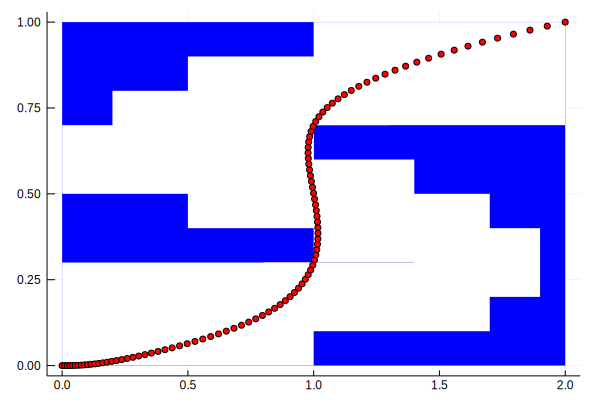

In [5]:
simpleplot(domain, boxes,eval_poly)